# MRS second order response
In this notebook we derive a correction for the spectral leak present in MRS band 3A detector images (see MIRI-TN-00002-KUL written by Dr. Bart Vandenbussche).

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

MIRI-TN-00002-KUL section 2: The MRS spectrometers are designed to cover the respective spectral band wavelength ranges in the first spectral order. A diffraction grating will yield maximum constructive interference for light of wavelength λ in the first order at an exit angle α. At the same exit angle α maximum constructive interference will also be seen for light of wavelength λ/2 (second order), λ/3 (third order), etc... Without a proper pre-selection of the wavelength bandpass entering the spectrometer, (parts of) these higher order spectra will be superimposed on the first order spectrum.  
  
Such an occurence is expected to happen in MRS band 3A due to a spectral leakage from the dichroic transmission in band 1B. This is shown below.

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
import scipy.interpolate as scp_interpolate
from scipy.ndimage import gaussian_filter1d
from astropy.io import fits
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# MRS spectral band of interest
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]

In [3]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'
MRSWaveCalDir = workDir+"MRSWaveCal/" 
MTSDir        = workDir+'notebooks/pyMTSSim/OUTPUT/'
MrsFilterTransmDir   = MRSWaveCalDir+"MrsFilterTransmissions/"

In [4]:
# Populate dictionaries with the wavelength, pixel size and validity maps 
# (corresponding to the detector plane)

sliceMap  = {}
sizeMap   = {}
validMap  = {}
lambdaMap = {}

for band in bands:
    print "Band {}".format(band)
    d2cMaps         = funcs.load_obj('d2cMaps_band{}_tr10pc'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band,d2cMaps)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


In [5]:
# Populate dictionaries with maps of L_sky
ip_Lsky = {}
for BBTemp in ["400K", "600K", "800K"]:  
    tabLSky = fits.open(MTSDir+ "MTSEquivalentLsky" + BBTemp + ".fits" )[1]
    ip_Lsky[BBTemp] = scp_interpolate.interp1d(tabLSky.data["wave"], tabLSky.data["L_sky"]*1000., kind='cubic')

In [6]:
# Populate dictionaries with maps of S_pix [DN/sec] and dS_pix (the error)
# S_pix is the average slope of the BB measurement with the average slope of the
# background measurement subtracted.
# We also populate the Bad pixel map (0 = ok, 1 = do not use)

#-- Uncomment to re-run
S_pixMap = {}
dS_pixMap = {}
BadPixelMap ={}
for BBTemp in ["400K","600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    S_pixMap[BBTemp] = {}
    dS_pixMap[BBTemp] = {}
    BadPixelMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        S_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        dS_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        BadPixelMap[BBTemp][band] = np.full( validMap[band].shape, 0 )
        hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,corr1='',output='filename')[0])
        slopeHOLE = hdulist[0].data[0,:,:]
        dslopeHOLE = hdulist[0].data[1,:,:]
        maskHOLE = hdulist[0].data[2,:,:]
        hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,corr1='',output='filename')[1])
        slopeBLANK = hdulist[0].data[0,:,:]
        dslopeBLANK = hdulist[0].data[1,:,:]
        maskBLANK = hdulist[0].data[2,:,:]
        sel = (validMap[band]==1) & (maskHOLE==0) & (maskBLANK==0)
        S_pixMap[BBTemp][band][sel] = slopeHOLE[sel] - slopeBLANK[sel]
        dS_pixMap[BBTemp][band][sel] = np.sqrt(dslopeHOLE[sel]**2 + dslopeBLANK[sel]**2)
        BadPixelMap[BBTemp][band][(validMap[band]==1) & (maskHOLE>0) & (maskBLANK>0)] = 1

BBTemp 400K
BBTemp 600K
BBTemp 800K


In [7]:
R_n1,R_n2 = {},{}
dR_n1,dR_n2 = {},{}
for band in bands:
    print "Band {}".format(band)
    R_n1[band],R_n2[band] = {},{}
    dR_n1[band],dR_n2[band] = {},{}
    for relation in ['800K_600K','800K_400K','600K_400K']:
        Resp_order1,Resp_order2 = [np.full((1024,1032),np.nan) for i in range(2)]
        dResp_order1,dResp_order2 = [np.full((1024,1032),np.nan) for i in range(2)]
        sel = (lambdaMap[band] !=0)
        # solve 2x2 system of radiometric equations
        Teff1,Teff2 = relation.split('_')[0],relation.split('_')[1]
        #-- coefficients
        a1 = S_pixMap[Teff1][band][sel]
        a2 = S_pixMap[Teff2][band][sel]
        b1 = ip_Lsky[Teff1](lambdaMap[band][sel])*sizeMap[band][sel]
        b2 = ip_Lsky[Teff2](lambdaMap[band][sel])*sizeMap[band][sel]
        c1 = ip_Lsky[Teff1](lambdaMap[band][sel]/2.)*sizeMap[band][sel]
        c2 = ip_Lsky[Teff2](lambdaMap[band][sel]/2.)*sizeMap[band][sel]

        Resp_order1[sel] = (-a1/c1 + a2/c2) / (-b1/c1 + b2/c2)
        Resp_order2[sel] = (-a1/b1 + a2/b2) / (-c1/b1 + c2/b2)

        R_n1[band][relation] = Resp_order1
        R_n2[band][relation] = Resp_order2
        
        # error propagation
        da1 = dS_pixMap[Teff1][band][sel]
        da2 = dS_pixMap[Teff2][band][sel]
        
        dResp_order1[sel] = np.sqrt((-1./c1)**2 * da1**2 + (1./c2)**2 * da2**2) * abs(1./ (-b1/c1 + b2/c2))
        dResp_order2[sel] = np.sqrt((-1./b1)**2 * da1**2 + (1./b2)**2 * da2**2) * abs(1./ (-c1/b1 + c2/b2))
        
        dR_n1[band][relation] = dResp_order1
        dR_n2[band][relation] = dResp_order2

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


<IPython.core.display.Javascript object>


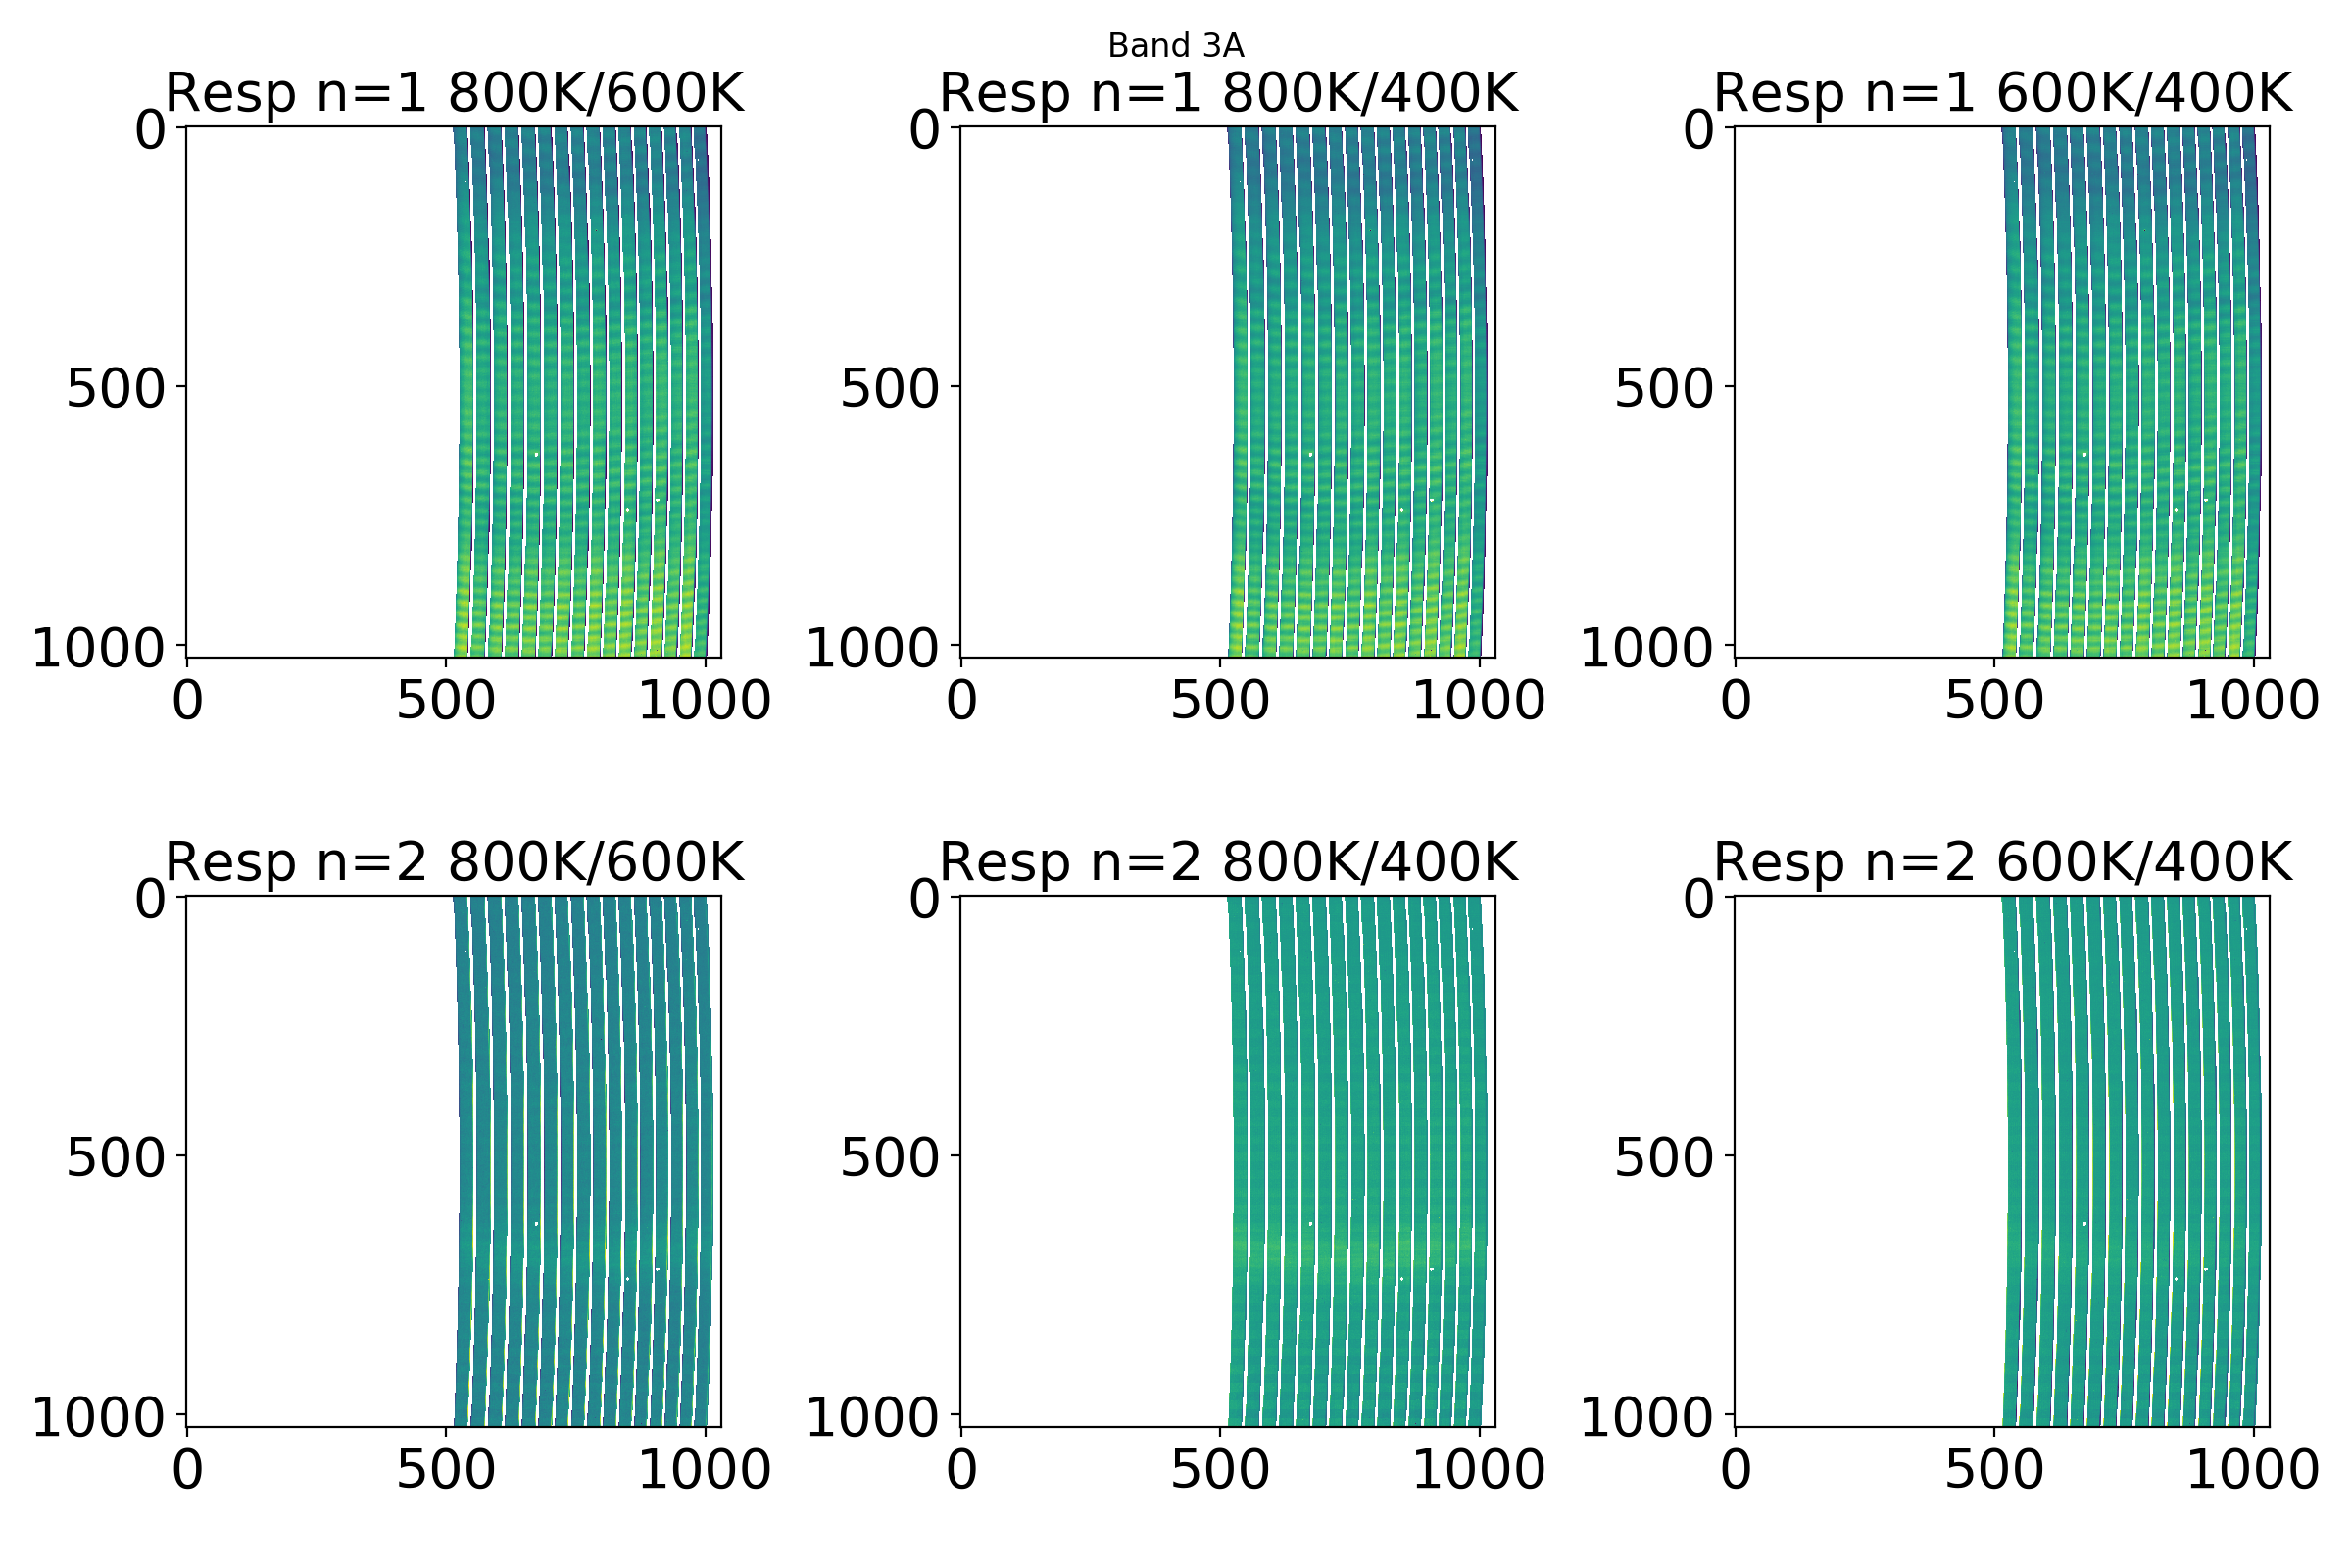

In [8]:
band = '3A'
fig,axs = plt.subplots(2,3,figsize=(12,8))
plt.suptitle('Band {}'.format(band),fontsize=12)
axs[0,0].imshow(R_n1[band]['800K_600K'])
axs[0,0].set_title('Resp n=1 800K/600K')
axs[1,0].imshow(R_n2[band]['800K_600K'])
axs[1,0].set_title('Resp n=2 800K/600K')
axs[0,1].imshow(R_n1[band]['800K_400K'])
axs[0,1].set_title('Resp n=1 800K/400K')
axs[1,1].imshow(R_n2[band]['800K_400K'])
axs[1,1].set_title('Resp n=2 800K/400K')
axs[0,2].imshow(R_n1[band]['600K_400K'])
axs[0,2].set_title('Resp n=1 600K/400K')
axs[1,2].imshow(R_n2[band]['600K_400K'])
axs[1,2].set_title('Resp n=2 600K/400K')
plt.tight_layout()

<IPython.core.display.Javascript object>


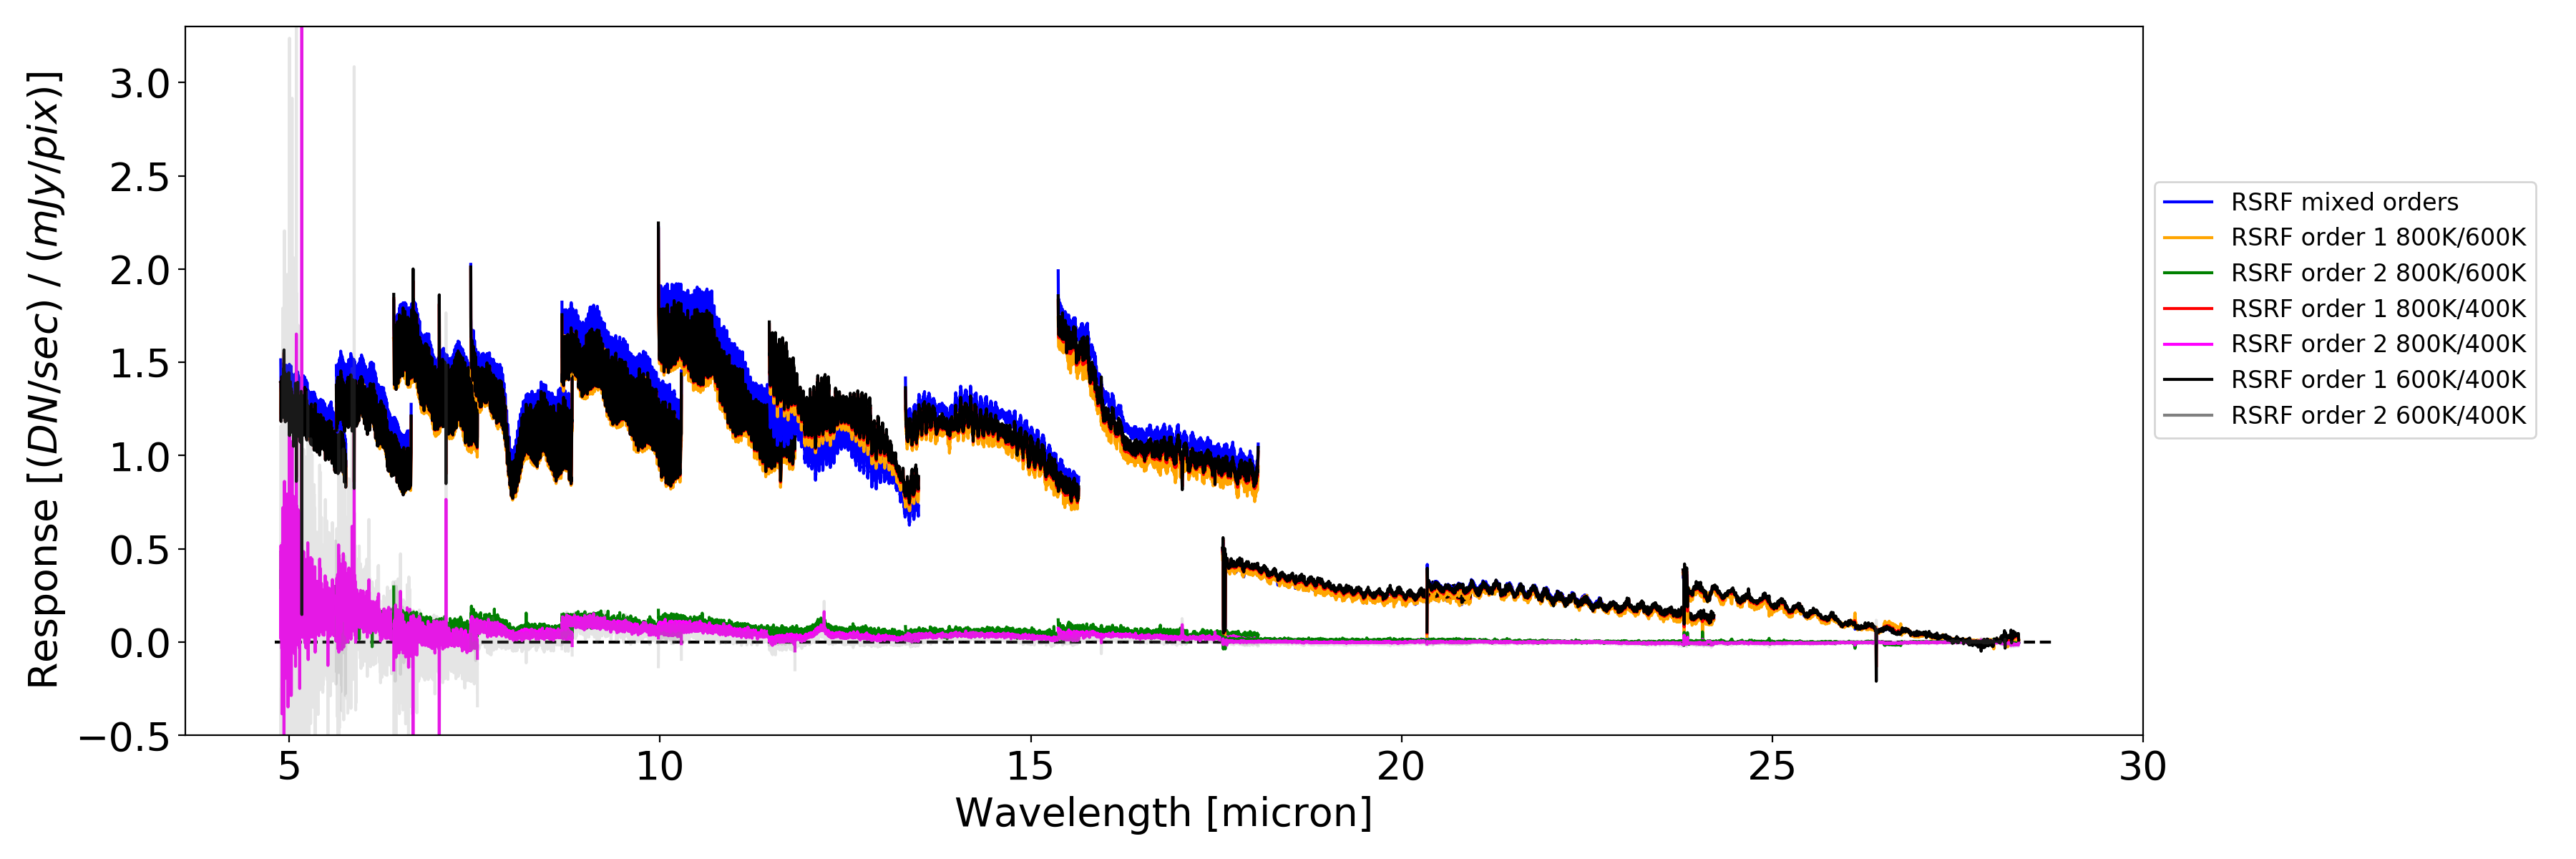

In [20]:
# plt.close('all')
fig = plt.figure(figsize=(18,6))
for band in bands:
    fringe_img,photom_img = funcs.get_cdps(band,cdpDir)[:2]
    # plot trace in pixel slice
    d2cMaps  = funcs.load_obj('d2cMaps_band{}_tr10pc'.format(band),path=d2cMapDir)
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
    
    plt.plot(lambdaMap[band][ypos,xpos],(photom_img*fringe_img)[ypos,xpos],'b')
    plt.plot(lambdaMap[band][ypos,xpos],R_n1[band]['800K_600K'][ypos,xpos],'orange')
    plt.plot(lambdaMap[band][ypos,xpos],R_n2[band]['800K_600K'][ypos,xpos],'green')
    plt.plot(lambdaMap[band][ypos,xpos],R_n1[band]['800K_400K'][ypos,xpos],'red')
    plt.plot(lambdaMap[band][ypos,xpos],R_n2[band]['800K_400K'][ypos,xpos],'magenta')
    plt.plot(lambdaMap[band][ypos,xpos],R_n1[band]['600K_400K'][ypos,xpos],'k')
    plt.plot(lambdaMap[band][ypos,xpos],R_n2[band]['600K_400K'][ypos,xpos],'gray',alpha=0.2)
plt.hlines(0,4.8,28.8,'k',linestyle='dashed')
plt.ylim(-0.5,3.3)
legend_elements = [Line2D([0],[0],color='b',label='RSRF mixed orders'),
                   Line2D([0],[0],color='orange',label='RSRF order 1 800K/600K'),
                   Line2D([0],[0],color='green',label='RSRF order 2 800K/600K'),
                   Line2D([0],[0],color='red',label='RSRF order 1 800K/400K'),
                   Line2D([0],[0],color='magenta',label='RSRF order 2 800K/400K'),
                   Line2D([0],[0],color='k',label='RSRF order 1 600K/400K'),
                   Line2D([0],[0],color='gray',label='RSRF order 2 600K/400K')]
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Response $[(DN/sec)\; /\; (mJy/pix)]$')
plt.legend(handles=legend_elements,loc='center left',bbox_to_anchor=(1.,0.6),fontsize=12)
plt.tight_layout(rect=[0,0,0.85,1])

In [11]:
second_order_response = R_n2['3A']['600K_400K'].copy()

d2cMaps  = funcs.load_obj('d2cMaps_band{}_tr10pc'.format('3A'),path=d2cMapDir)

smoothed_second_order_response = np.full((1024,1032),np.nan)
for islice in range(1,d2cMaps['nslices']+1):
    print 'Slice {}'.format(islice)
    alphapositions = funcs.slice_alphapositions('3A',d2cMaps,sliceID=islice)
    for alphaposition in alphapositions:
        ypos,xpos = funcs.detpixel_trace('3A',d2cMaps,sliceID=islice,alpha_pos=alphaposition)
        sel = ~np.isnan(second_order_response[ypos,xpos])
        
        smooth_spec = gaussian_filter1d(second_order_response[ypos,xpos][sel],10)

        smoothed_second_order_response[ypos[sel],xpos[sel]] = smooth_spec

Slice 1
Slice 2
Slice 3
Slice 4
Slice 5
Slice 6
Slice 7
Slice 8
Slice 9
Slice 10
Slice 11
Slice 12
Slice 13
Slice 14
Slice 15
Slice 16


In [13]:
# Read the measured transmission curves from the csv files
# zeroth colum is wavelength [micrometer]
# first column is room temperature transmission
# second column is 7K transmission
col = 2
filterWave= np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1a.csv", delimiter=";")[:,0]
D1A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1a.csv", delimiter=";")[:,col]/100.
D1B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1b.csv", delimiter=";")[:,col]/100.
D1C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1c.csv", delimiter=";")[:,col]/100.
D2A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2a.csv", delimiter=";")[:,col]/100.
D2B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2b.csv", delimiter=";")[:,col]/100.
D2C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2c.csv", delimiter=";")[:,col]/100.
D3A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3a.csv", delimiter=";")[:,col]/100.
D3B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3b.csv", delimiter=";")[:,col]/100.
D3C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3c.csv", delimiter=";")[:,col]/100.

system_transmission = D1A*D2A*(1-D3A)

<IPython.core.display.Javascript object>


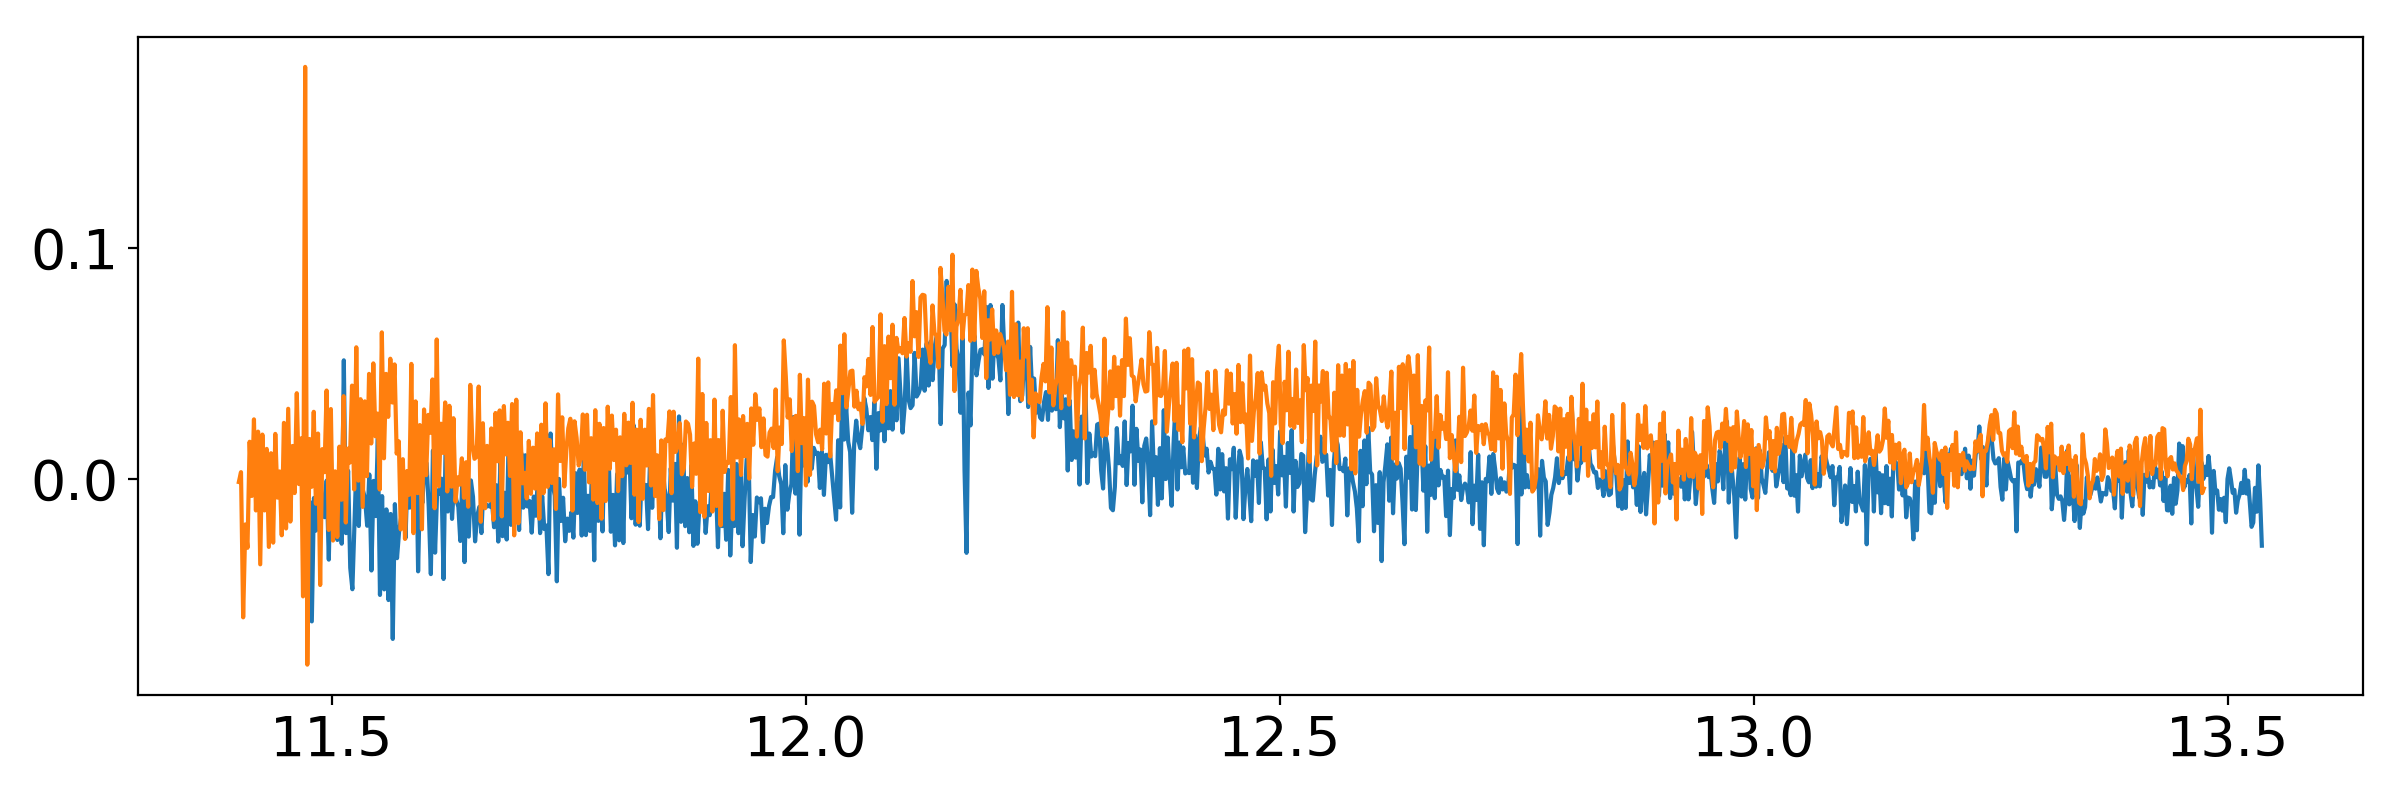

In [124]:
ypos,xpos1 = funcs.detpixel_trace('3A',d2cMaps,sliceID=4,alpha_pos=0.)
ypos,xpos2 = funcs.detpixel_trace('3A',d2cMaps,sliceID=11,alpha_pos=0.)

plt.figure(figsize=(12,4))
plt.plot(lambdaMap['3A'][ypos,xpos1],second_order_response[ypos,xpos1])
plt.plot(lambdaMap['3A'][ypos,xpos2]-0.1,second_order_response[ypos,xpos2])
plt.tight_layout()

Slice 4


<IPython.core.display.Javascript object>


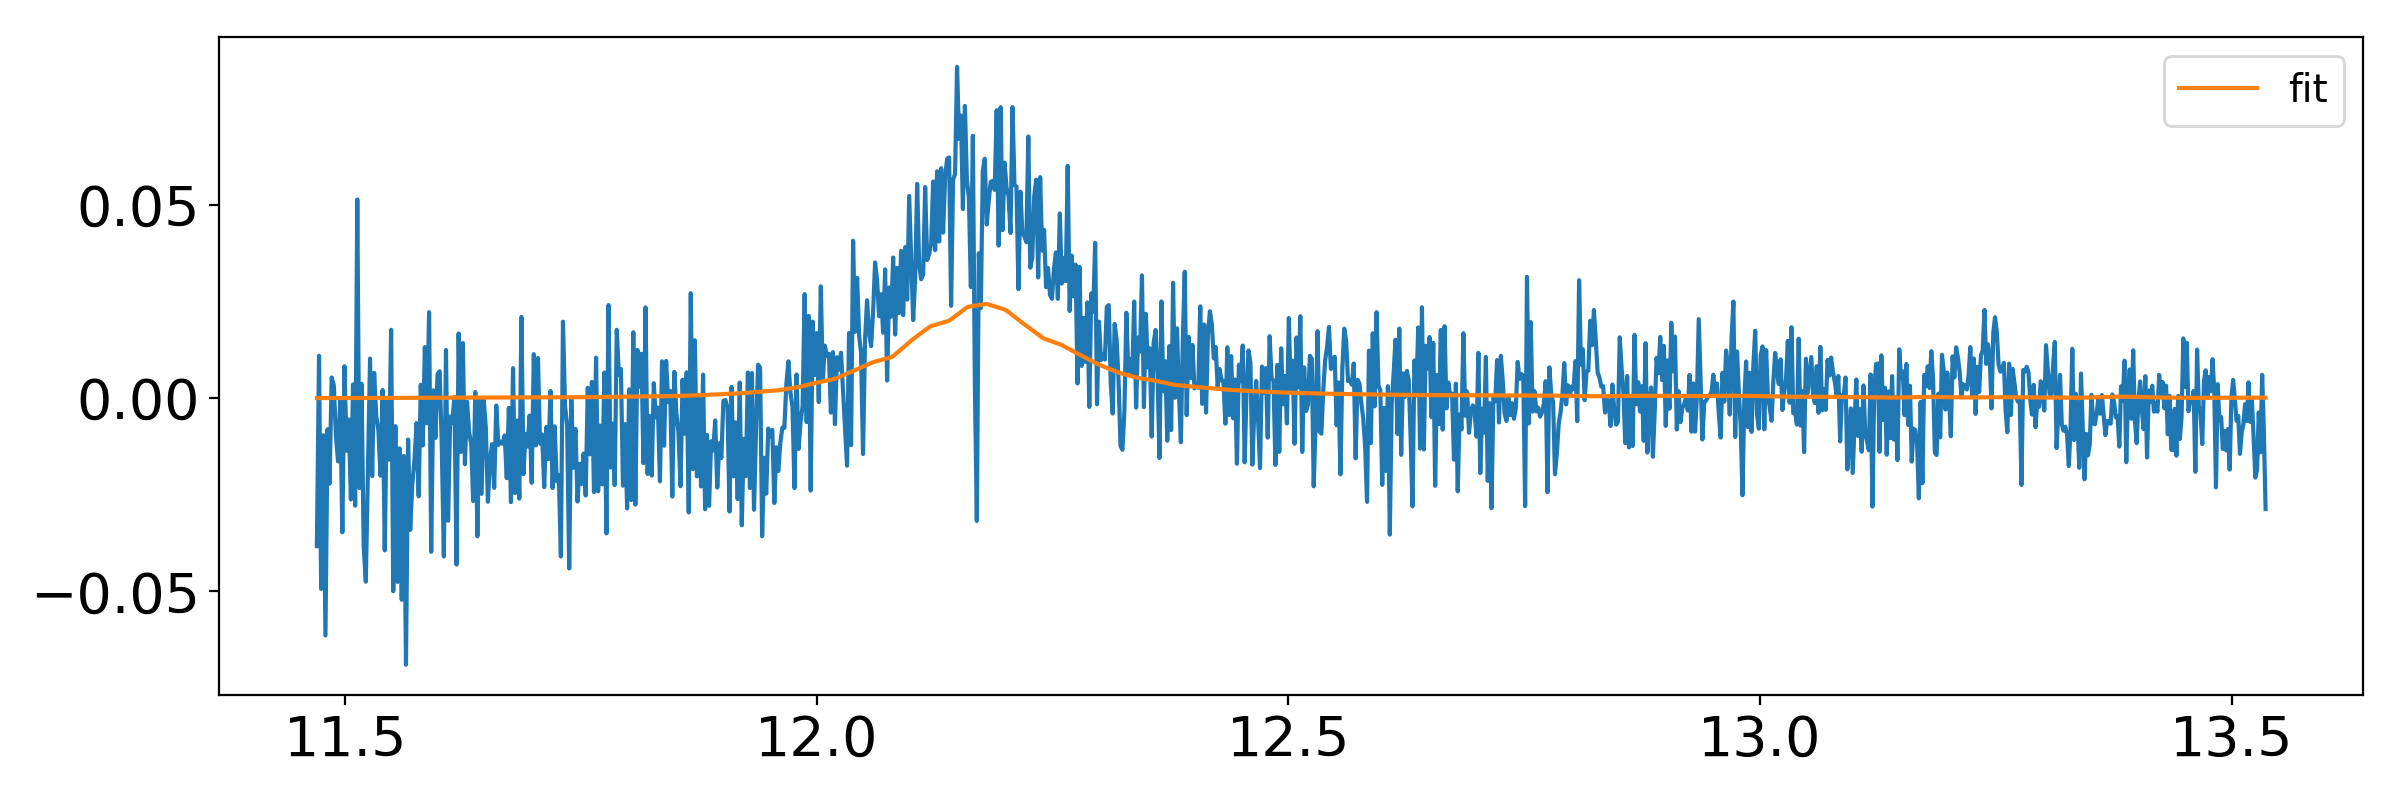

In [121]:
d2cMaps  = funcs.load_obj('d2cMaps_band{}_tr10pc'.format('3A'),path=d2cMapDir)

factors = np.arange(0,2.5,0.005)
interp_transm = scp_interpolate.interp1d(filterWave*2.,system_transmission)
# second_order_response_noNeg = second_order_response.copy()
# second_order_response_noNeg[second_order_response_noNeg<0] = 0

factor_image = np.full((1024,1032),np.nan)
for islice in [11]: # range(1,d2cMaps['nslices']+1):
    print 'Slice {}'.format(islice)
#     alphapositions = funcs.slice_alphapositions('3A',d2cMaps,sliceID=islice)
    plt.figure(figsize=(12,4))
    for alphaposition in [0]:# alphapositions:
        ypos,xpos = funcs.detpixel_trace('3A',d2cMaps,sliceID=islice,alpha_pos=alphaposition)
        sel = (lambdaMap['3A'][ypos,xpos]>12.) & (lambdaMap['3A'][ypos,xpos]<12.3) & ~np.isnan(second_order_response[ypos,xpos])
        
#         smooth_spec = gaussian_filter1d(second_order_response[ypos,xpos][sel],10)
#         fac = smooth_spec.max()/interp_transm(lambdaMap['3A'][ypos,xpos][sel]).max()
        
        chi_square = []
        for factor in factors:
            chi_square.append( (second_order_response[ypos,xpos][sel] - factor*interp_transm(lambdaMap['3A'][ypos,xpos][sel])).sum()**2 )
        
#         plt.figure()
#         plt.plot(factors,chi_square)
#         plt.tight_layout()
        
        fac = factors[np.argmin(np.array(chi_square))]
        
        plt.plot(lambdaMap['3A'][ypos,xpos][sel],second_order_response[ypos,xpos][sel])
#         plt.plot(lambdaMap['3A'][ypos,xpos][sel],smooth_spec)
        plt.plot(lambdaMap['3A'][ypos,xpos][sel],fac*interp_transm(lambdaMap['3A'][ypos,xpos][sel]),label='fit')
        
#         print fac
        if alphaposition in [alphapositions[-2],alphapositions[-1]]:
            factor_image[ypos[sel],xpos[sel]] = 0
        else:
            factor_image[ypos[sel],xpos[sel]] = fac
    plt.legend()
    plt.tight_layout()

<IPython.core.display.Javascript object>


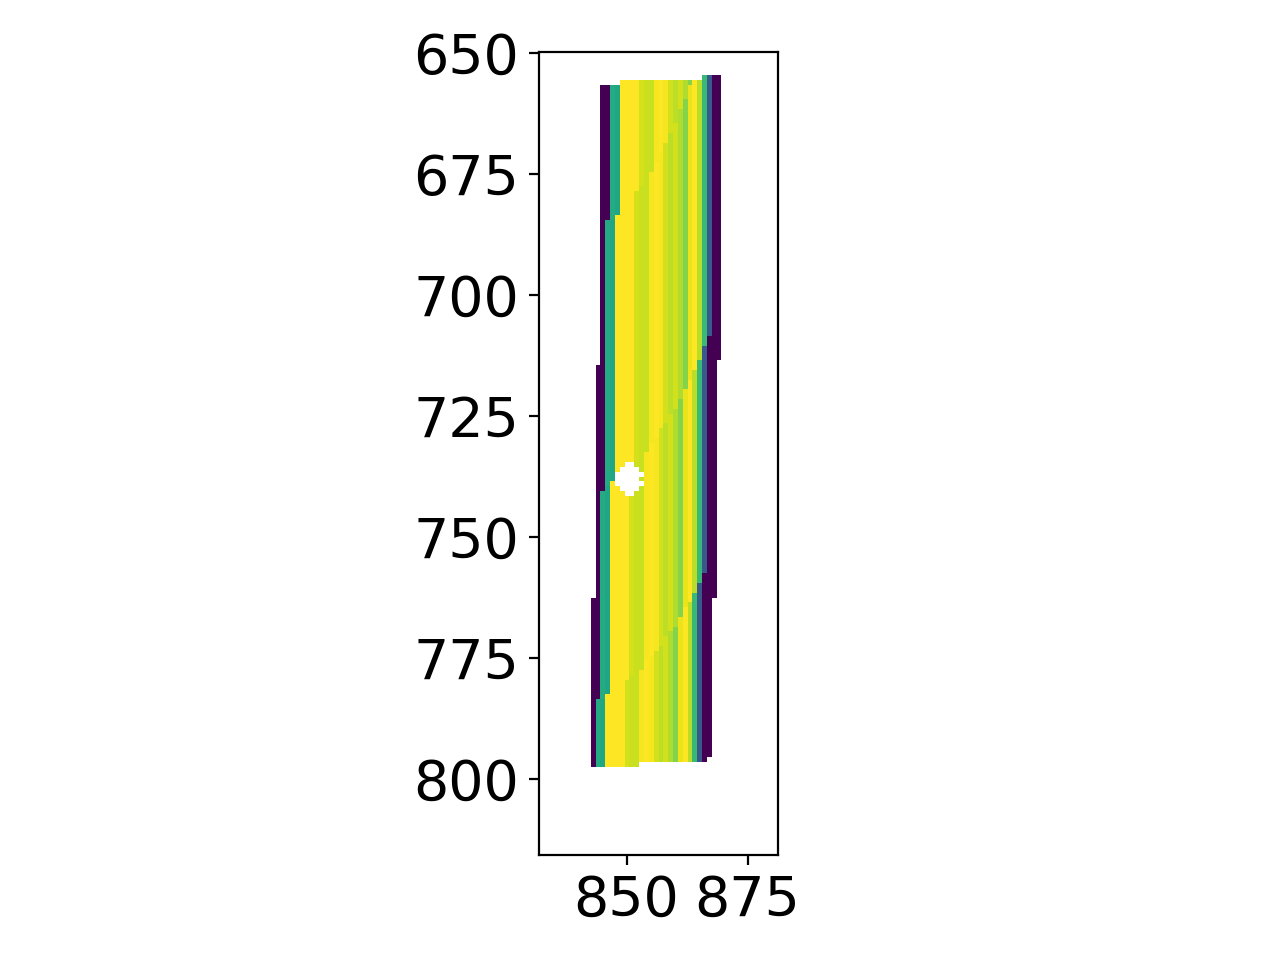

In [117]:
plt.figure()
plt.imshow(factor_image,vmin=0.,vmax=2.5)
plt.tight_layout()

<IPython.core.display.Javascript object>


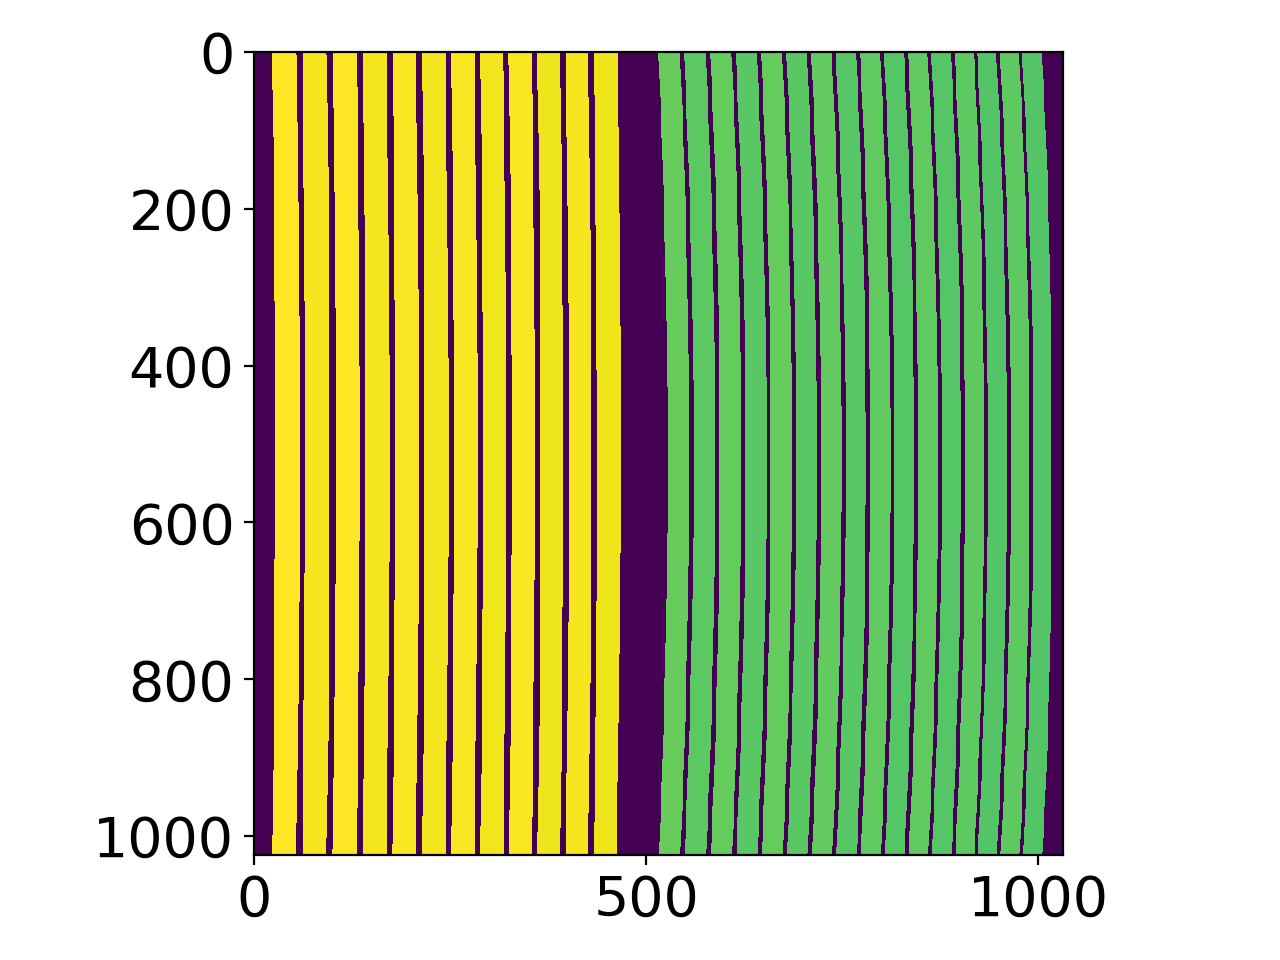

In [108]:
plt.figure()
plt.imshow(d2cMaps['sliceMap'])
plt.tight_layout()

<IPython.core.display.Javascript object>


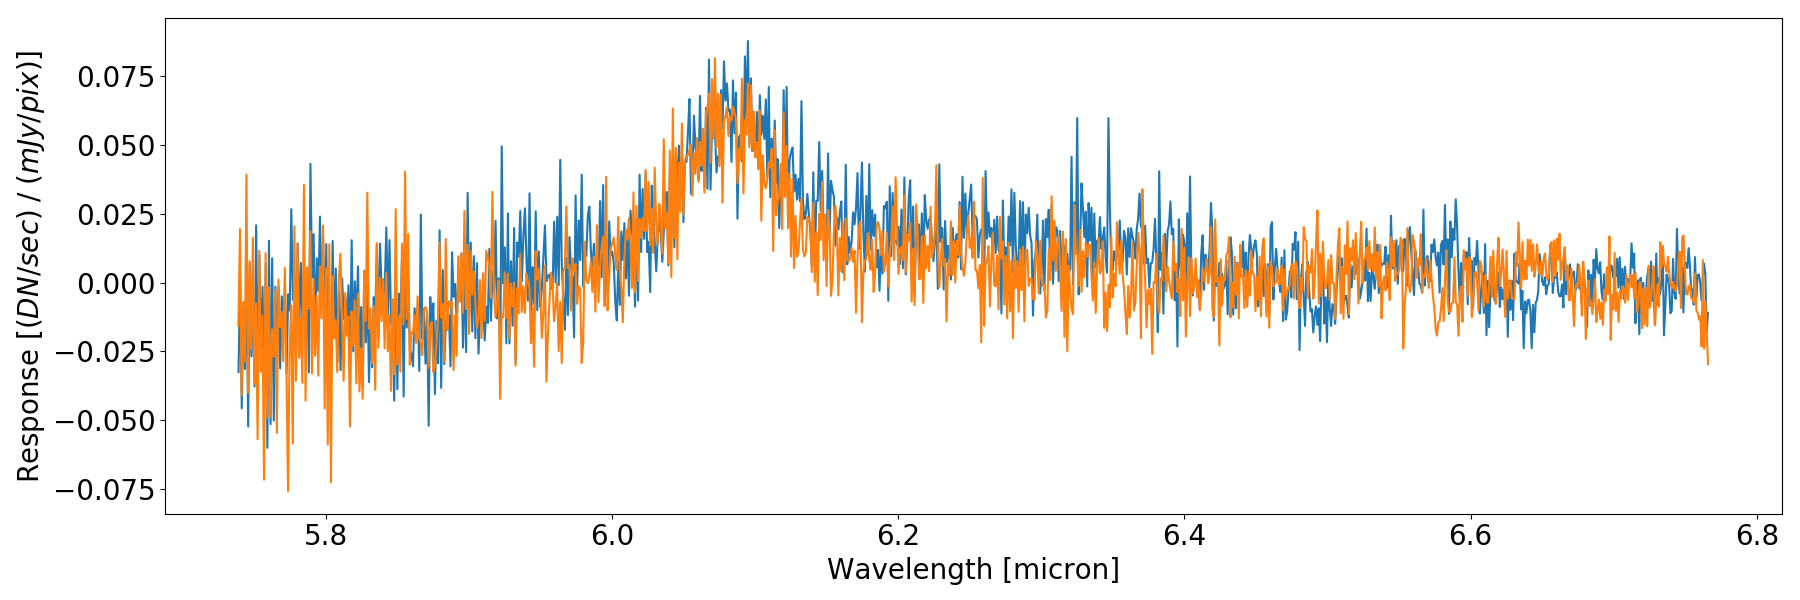

In [55]:
# test_img = smoothed_second_order_response.copy()
# for i in range(1031):
#     test_img[:,i] = (smoothed_second_order_response[:,i+1]+smoothed_second_order_response[:,i])/2.
    
# fig,axs = plt.subplots(1,3,figsize=(14,6))
# axs[0].imshow(second_order_response,vmin=0,vmax=0.1)
# axs[1].imshow(smoothed_second_order_response,vmin=0,vmax=0.1)
# axs[2].imshow(test_img,vmin=0,vmax=0.1)
# plt.tight_layout()

band = '3A'
# plot trace in pixel slice
d2cMaps  = funcs.load_obj('d2cMaps_band{}_tr10pc'.format(band),path=d2cMapDir)
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=5,alpha_pos=-1.)
sel = ~np.isnan(second_order_response[ypos,xpos])

plt.figure(figsize=(18,6))
plt.plot(lambdaMap[band][ypos,xpos]/2.,second_order_response[ypos,xpos])
xpos+=2
plt.plot(lambdaMap[band][ypos,xpos]/2.,second_order_response[ypos,xpos])
# plt.plot(lambdaMap[band][ypos,xpos],smoothed_second_order_response[ypos,xpos])
# plt.plot(lambdaMap[band][ypos,xpos][sel],gaussian_filter1d(second_order_response[ypos,xpos][sel],10))
# plt.plot(lambdaMap[band][ypos,xpos]/2.,test_img[ypos,xpos])
# sel = (filterWave>(lambdaMap[band][ypos,xpos]/2.).min()) & (filterWave<(lambdaMap[band][ypos,xpos]/2.).max())
# plt.plot(filterWave[sel],system_transmission[sel])
# plt.plot(filterWave[sel],system_transmission[sel]*2.5)
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Response $[(DN/sec)\; /\; (mJy/pix)]$')
plt.tight_layout()

### Remarks:
* The first and second spectral order responses determined from the different pairs of observations agree quite well, though not perfectly. We have found that a non-zero linear term in the non-linearity correction is the primal cause for this offset between responses.

## Save first and second order response to CDP

In [9]:
# specify version to be saved
version = "7B.03.02"

In [10]:
# save responses to CDP
oldCdp = fits.open(cdpDir+"MIRI_FM_MIRIFUSHORT_SHORT_PHOTOM_06.03.02.fits")
dq_def = oldCdp[4]

In [11]:
outDir = cdpDir+"CDP7/"

In [12]:
def makeHeader(detector="MIRIFUSHORT", channel="12", band="SHORT"):
    hdu0 = fits.PrimaryHDU()
    hdu0.header["TELESCOP"]="JWST"
    hdu0.header["INSTRUME"]="MIRI"
    hdu0.header["MODELNAM"]=("FM", "Instrument model name")
    hdu0.header["DETECTOR"]=detector
    hdu0.header["DETSETNG"]="N/A"
    hdu0.header["READPATT"]="N/A"
    hdu0.header["SUBARRAY"]="GENERIC"
    hdu0.header["SUBSTRT1"]= 1                                            
    hdu0.header["SUBSIZE1"]= 1032                                              
    hdu0.header["SUBSTRT2"]= 1                                                
    hdu0.header["SUBSIZE2"]= 1024                                           
    hdu0.header["FASTAXIS"]= 1                                               
    hdu0.header["SLOWAXIS"]= 2
    hdu0.header["CHANNEL"] = channel
    hdu0.header["BAND"]    = band
    hdu0.header["FILENAME"]= "MIRI_FM_"+detector+"_"+channel+band+"_PHOTOM_{}.fits".format(version)
    hdu0.header["DATE"]="2018-12-20"
    hdu0.header["VERSION"] = version
    hdu0.header["USEAFTER"] ="2000-01-01T00:00:00"
    hdu0.header["AUTHOR"]  ="Bart Vandenbussche, Ioannis Argyriou"
    hdu0.header["ORIGIN"]  = "MIRI European Consortium"
    hdu0.header["EXP_TYPE"]= "MIR_MRS"
    hdu0.header["REFTYPE"] ="PHOTOM"
    hdu0.header["DESCRIP"] = 'CDP-7 MIRI MRS response'
    hdu0.header["PEDIGREE"] = 'GROUND'
    hdu0.header["PHOTMJSR"] = 42.5
    hdu0.header["PHOTUJA2"] = 1000.0
    hdu0.header.add_history("DOCUMENT: MIRI-TN-00003-KUL issue 1.2")
    hdu0.header.add_history("SOFTWARE: MIRICLE ")
    hdu0.header.add_history("DATA USED: RAL FM data obsId 11282 .. 11287")
    hdu0.header.add_history("DIFFERENCES: 06.03.00 Detector plane calibration (new format)")
    hdu0.header.add_history("DIFFERENCES: 06.03.01 Corrected error in PIXSIZ extension")
    hdu0.header.add_history("DIFFERENCES: 06.03.02 Fringe flat 06.02.00 applied")
    hdu0.header.add_history("DIFFERENCES: 7B.03.00 Renumbered to CDP7 Beta / fixed USEAFTER")
    hdu0.header.add_history("DIFFERENCES: 7B.03.01 Introduced 0.55 factor offset.")
    hdu0.header.add_history("DIFFERENCES: Used 10% transmission slice mask.")
    hdu0.header.add_history("DIFFERENCES: {} Separated the first and second order diffraction grating response.".format(version))
    return hdu0

## LONG SHORT = 3A / 4A - Diffraction grating first order response

In [21]:
hdu0 = makeHeader(detector="MIRIFULONG", channel="34", band="SHORT")
resp = R_n1["4A"]['600K_400K'].copy()
err = dR_n1["4A"]["600K_400K"].copy()
size = sizeMap["4A"].copy()

sel = (validMap["3A"]==1)
resp[sel] = R_n1["3A"]["600K_400K"][sel]
err[sel] = dR_n1["3A"]["600K_400K"][sel]
size[sel] = sizeMap["3A"][sel]

sel = (( validMap["3A"] + validMap["4A"] )==1)
# resp[sel] = resp[sel] # /ff["LONGSHORT"][sel]

dq = np.full( validMap["3A"].shape, 2 )
sel = (validMap["3A"]==1)
dq[sel] = 0
sel = (validMap["4A"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["800K"]["3A"]
dq = dq + BadPixelMap["800K"]["4A"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFULONG_34SHORT_PHOTOM_7B.03.02.fits",overwrite=True )

<IPython.core.display.Javascript object>


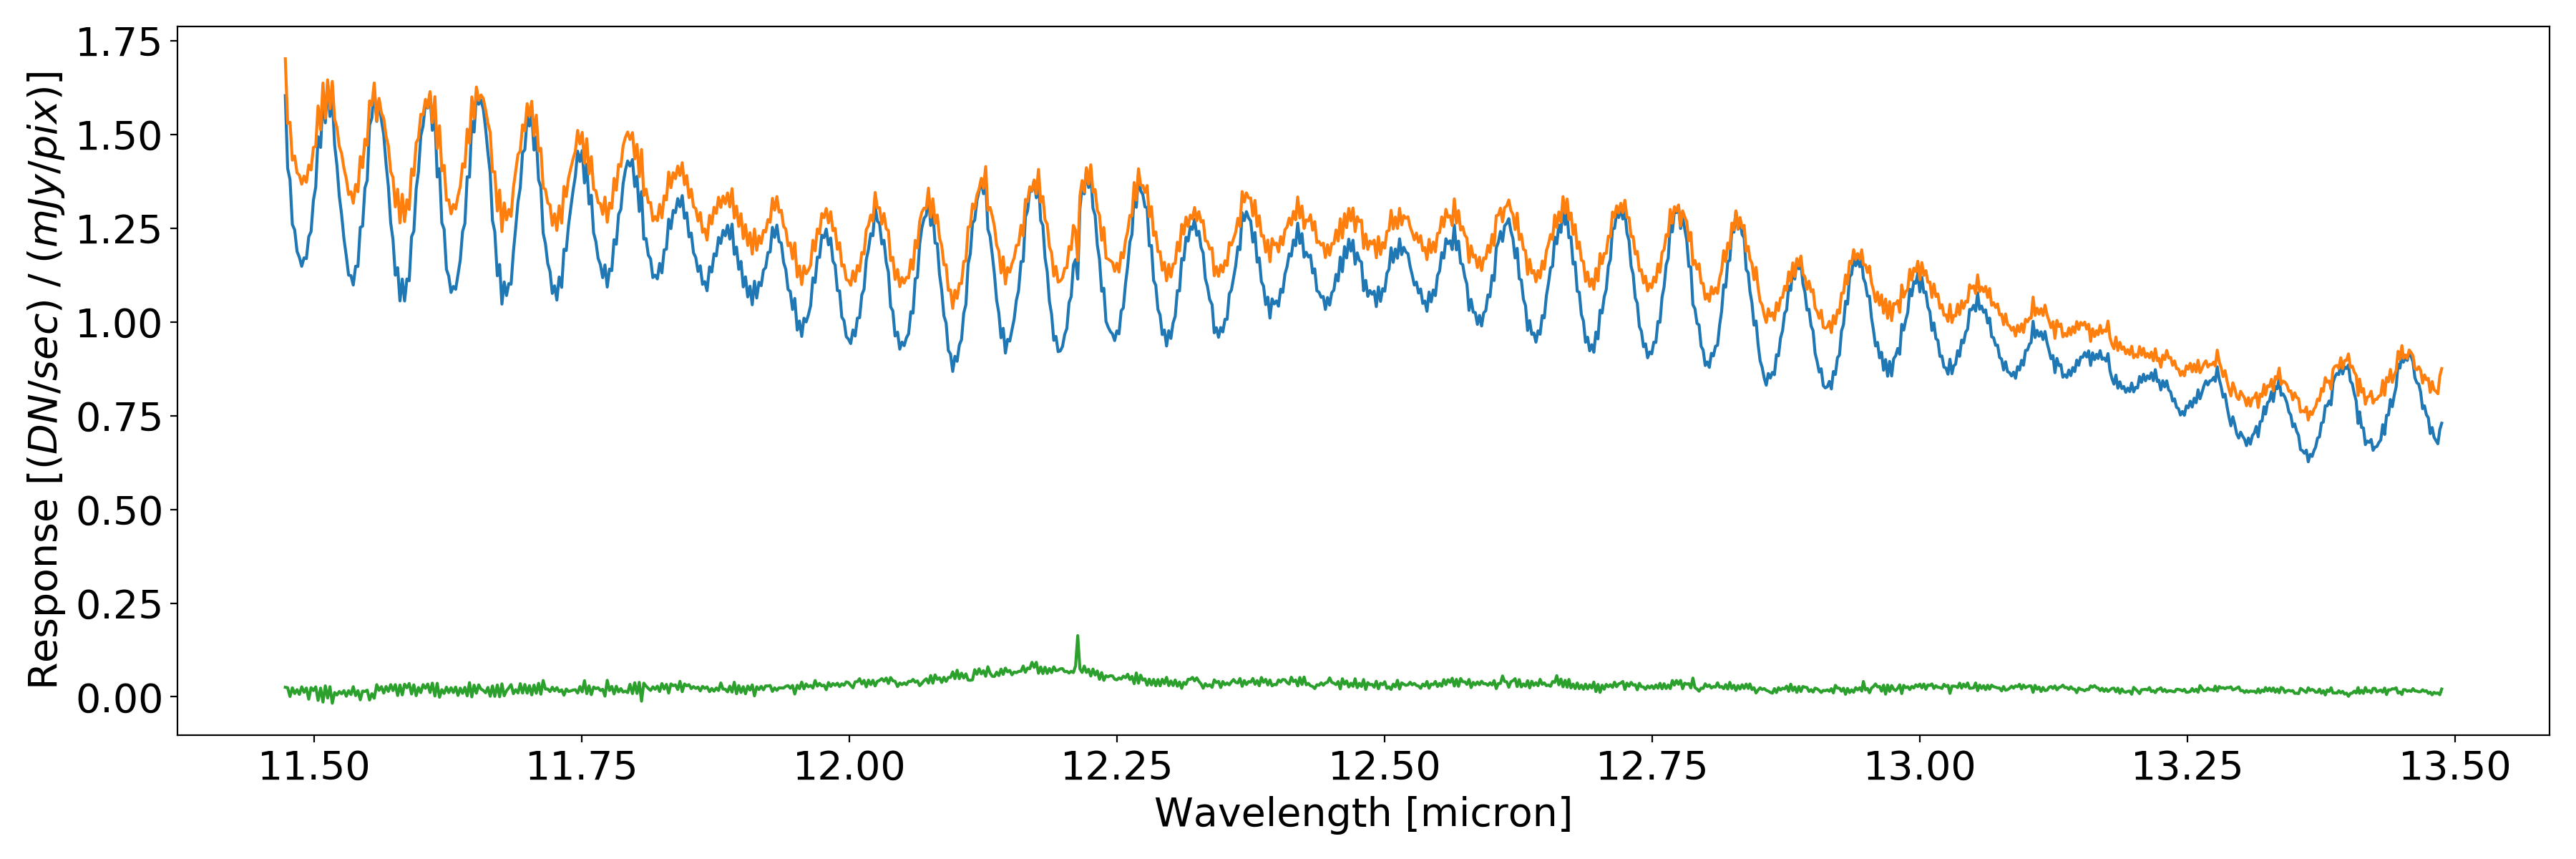

In [18]:
# plt.figure(figsize=(11,7))
# plt.imshow(resp, interpolation="nearest", cmap='jet')
# clb = plt.colorbar()
# clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
# plt.title("Response LONG SHORT (4A/3A)")
# plt.tight_layout()

# plt.figure(figsize=(11,7))
# plt.imshow(resp, interpolation="nearest", cmap='jet',vmax=0.5)
# clb = plt.colorbar()
# clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
# plt.title("Response LONG SHORT (4A/3A)")
# plt.tight_layout()

band = '3A'
fringe_img,photom_img = funcs.get_cdps(band,cdpDir)[:2]
fringe_err,photom_err = funcs.get_cdps(band,cdpDir,output='img_error')[:2]
# plot trace in pixel slice
d2cMaps  = funcs.load_obj('d2cMaps_band{}_tr10pc'.format(band),path=d2cMapDir)
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)

plt.figure(figsize=(18,6))
plt.plot(lambdaMap[band][ypos,xpos],(photom_img*fringe_img)[ypos,xpos])
plt.plot(lambdaMap[band][ypos,xpos],resp[ypos,xpos])
plt.plot(lambdaMap[band][ypos,xpos],R_n2["3A"]['800K_400K'][ypos,xpos])# second_order_response[ypos,xpos])
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Response $[(DN/sec)\; /\; (mJy/pix)]$')
plt.tight_layout()

## LONG SHORT = 3A / 4A - Diffraction grating second order response

In [22]:
hdu0 = makeHeader(detector="MIRIFULONG", channel="34", band="SHORT")
resp = R_n2["4A"]['600K_400K'].copy()
err = dR_n2["4A"]["600K_400K"].copy()
size = sizeMap["4A"].copy()

sel = (validMap["3A"]==1)
resp[sel] = R_n2["3A"]["600K_400K"][sel]
err[sel] = dR_n2["3A"]["600K_400K"][sel]
size[sel] = sizeMap["3A"][sel]

sel = (( validMap["3A"] + validMap["4A"] )==1)
# resp[sel] = resp[sel] # /ff["LONGSHORT"][sel]

dq = np.full( validMap["3A"].shape, 2 )
sel = (validMap["3A"]==1)
dq[sel] = 0
sel = (validMap["4A"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["800K"]["3A"]
dq = dq + BadPixelMap["800K"]["4A"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFULONG_34SHORT_SECONDORDER_PHOTOM_7B.03.02.fits",overwrite=True )